In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy
import pandas as pd 
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import pickle 
import torchvision.transforms as TT 


In [4]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [5]:
BASE_IMAGE_DIR= "ReinforcementImages"


In [6]:
from SegmentationAI import Decider 

dec = Decider() 


In [10]:
# TODO - Load images with their target values? 
resize_factor = T.Resize((128,128), antialias=True)
def load_and_clean(img_path):
    img = read_image(img_path,ImageReadMode.RGB)
    img = resize_factor.forward(img)  
    img = TT.ConvertImageDtype(torch.float32).forward(img) 

#     img = img.float() 
    img = img.unsqueeze(0) 
    
    img = dec.image_map(img) 
#     show(img) 
    
    return img 
possible_moves = ['up','left','right']

data_points = [] 

categorical_variables = {}
c_v_idx = 0 

for file in os.listdir(BASE_IMAGE_DIR):
    moves = set(file.split("_")).intersection(possible_moves) 
    formatted = [] 
    for m in possible_moves:
        if m in moves:
            formatted.append(m) 
    
    moves = " ".join(formatted)  
    if moves not in categorical_variables:
        categorical_variables[moves] = c_v_idx 
        c_v_idx += 1 
    moves = categorical_variables[moves] 
     
        
    img = load_and_clean(f"{BASE_IMAGE_DIR}/{file}")  
    data_points.append((img, moves))     

In [12]:
print(categorical_variables) 

{'up': 0, 'up left': 1, 'right': 2, 'up right': 3, 'left': 4, '': 5}


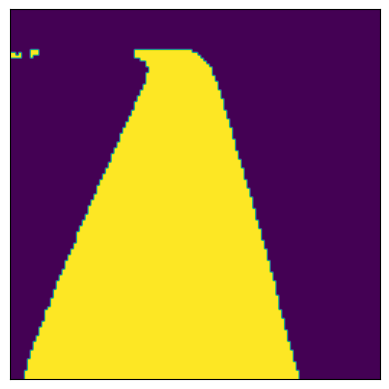

In [13]:
show(data_points[0][0].squeeze(0)) 

In [14]:
class CDS(Dataset):
    def __init__(self, lof_points):
        self.lof_points = lof_points 
    def __len__(self):
        return len(self.lof_points) 
    
    def __getitem__(self, idx):
        pair = self.lof_points[idx] 
        return pair 



dl_points = CDS(data_points) 
splits = torch.utils.data.random_split(dl_points, [len(data_points) - 10, 10])    
train = splits[0]
val = splits[1]
 

In [15]:

def highest_idx(vals):
    m = None
    out_idx = None 
    
    for idx, val in enumerate(vals):
        if m is None or val > m:
            m = val 
            out_idx = idx
    return out_idx 

class ImitationNN(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(in_features=128*128, out_features=len(categorical_variables)), 
#         )
        self.layers = nn.Sequential(
            nn.Linear(in_features=128*128, out_features=64*64), 
            nn.Linear(in_features=64*64, out_features=32*32), 
            nn.Linear(in_features=32*32, out_features=len(categorical_variables))
        )
        
        self.loss = nn.CrossEntropyLoss()
        
        
        
          
    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        feats, target = batch 
        
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        self.log("train_loss", loss, prog_bar=True)
        
        return loss 
          
        
    
    def validation_step(self, batch, batch_idx):
        feats, target = batch 
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        self.log("val_loss", loss, prog_bar=True)
        
        return loss 
          

    def forward(self, x):
        flatten = torch.flatten(x) 
        return self.layers(flatten)  

print(train[0][0].shape)
model = ImitationNN() 


torch.Size([1, 128, 128])


In [16]:
trainer = pl.Trainer(max_epochs=5,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=train, val_dataloaders=val) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 71.3 M
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
71.3 M    Trainable params
0         Non-trainable params
71.3 M    Total params
285.258   Total estimated model params size (MB)


/Users/ryankennedy/opt/anaconda3/envs/robotics/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████| 1928/1928 [03:30<00:00,  9.17it/s, v_num=100, train_loss=1.990]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:33<00:00,  9.01it/s, v_num=100, train_loss=1.690, val_loss=0.467]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:33<00:00,  9.04it/s, v_num=100, train_loss=1.460, val_loss=0.360]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:34<00:00,  8.97it/s, v_num=100, train_loss=1.300, val_loss=0.294]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  90%|███████████████████████████████████████████████████████████████████████████████████▋         | 9/10 [00:00<00:00, 53.80it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:32<00:00,  9.06it/s, v_num=100, train_loss=1.170, val_loss=0.255]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:32<00:00,  9.05it/s, v_num=100, train_loss=1.170, val_loss=0.229]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████| 1928/1928 [03:33<00:00,  9.04it/s, v_num=100, train_loss=1.170, val_loss=0.229]


In [17]:
if True:
    print("Saving mode!") 
    torch.save(model.state_dict(), "imitation_model_weights") 

Saving mode!


In [18]:
direct_mappings = {}

for key in categorical_variables:
    val = categorical_variables[key]
    direct_mappings[val] = key 

def predict(img):
    preds = model(img) 
    pred_idx = highest_idx(preds)
    
    return direct_mappings[pred_idx] 
    

In [19]:
test_files = []

for file in os.listdir("Images/"):
    img = load_and_clean(f"Images/{file}")
    test_files.append(img)
    
     

In [20]:
img = test_files[1]

show(img)
direct = predict(img) 
print(direct) 

IndexError: list index out of range

In [22]:
if True:
    print("Saving mode!") 
    torch.save(model.state_dict(), "imitation_model_weights") 

Saving mode!


In [21]:
print(direct_mappings) 

{0: 'up', 1: 'up left', 2: 'right', 3: 'up right', 4: 'left', 5: ''}
